In [143]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:
%%html
<style>
table{
    display: block
}

table th {
text-align: left;
}

table td {
text-align: left;
}

table img {
border: 1px solid black;
}
</style>


<img src="./images/usgs.png" style=" padding-top: 26px; float: left"/>
<img src="./images/WaveLabLogo.png" style="float: left"/>

# Wave Statistics

We make the following assumptions when calculating wave statistics:

1. Linear Wave Theory is applicable.
2. Mean water depth and waves are sufficiently constant over each 17 minute time series chunk (4096 poins of data collected at 4 Hz) in order to yield meaningful wave statistics.

In [145]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pytz

def plot_graph(x_data, y_data, title, x_label, y_label, size, name):
    
    _, ax = plt.subplots(figsize=size)
    ax.plot(x_data,y_data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    file_name = './images/%s.png' % name
    plt.savefig(file_name)
    return file_name
    

In [146]:
from wavelab.utilities.nc import (get_pressure, 
                                  get_air_pressure, 
                                  get_time, 
                                  get_datetimes,
                                  get_variable_attr,
                                  get_global_attribute)

sea_file = '../data/1_NYRIC_wv.nc'
baro_file = '../data/1_NYRIC_bp.nc'

# Load all of the data
sea_pressure_data = get_pressure(sea_file)
sea_milli = get_time(sea_file)
sea_date_times = get_datetimes(sea_file)

baro_pressure_data = get_air_pressure(baro_file)
baro_milli = get_time(baro_file)
baro_date_times = get_datetimes(baro_file)

# Interpolate the air pressure
baro_interp = np.interp(sea_milli, baro_milli, baro_pressure_data)

# Slice the data accordingly
itemindex = np.where(~np.isnan(baro_interp))
begin = itemindex[0][0]
end = itemindex[0][len(itemindex[0]) - 1]
corrected_pressure = sea_pressure_data[begin:end] - baro_interp[begin:end]
corrected_time = sea_milli[begin:end]
corrected_date_times = sea_date_times[begin:end]

#Get sensor orifice and land surface elevation
sensor_orifice1 = get_global_attribute(sea_file, 'sensor_orifice_elevation_at_deployment_time')
sensor_orifice2 = get_global_attribute(sea_file, 'sensor_orifice_elevation_at_retrieval_time')
land_surface1 = get_global_attribute(sea_file, 'initial_land_surface_elevation')
land_surface2 = get_global_attribute(sea_file, 'final_land_surface_elevation')
orifice_elev = np.linspace(sensor_orifice1,sensor_orifice2,len(corrected_date_times))
land_elev = np.linspace(land_surface1,land_surface2,len(corrected_date_times))

def extract_level_accuracy(fname, attr):
    try:
        error = get_variable_attr(fname, attr, 'instrument_level_accuracy_in_meters')
    except:
        try:
            instrument = get_variable_attr(fname, attr, 'instrument_make')
        except:
            instrument = get_global_attribute(fname, 'sea_pressure_instrument_make')
        if instrument == 'TruBlue' or instrument == 'Level TROLL':
            error = 0.0106679996
        if instrument == 'Hobo':
            error = 0.021335999

    return error

instrument_level_accuracy = extract_level_accuracy(sea_file, 'sea_pressure') + \
    extract_level_accuracy(baro_file, 'air_pressure') 

Split the corrected sea pressure time series into chunks of 4096 points
(approximatley 17 minutes of 4 Hz data) with each chunk overlapping the preceding chunk
by 2048 points.

In [147]:
step = 2048
start_index = 0
end_index = 4096
p_chunks = []
t_chunks = []
dt_chunks = []
elev_chunks = []
orifice_chunks = []

while end_index < len(corrected_pressure):
    p_chunks.append(corrected_pressure[start_index:end_index])
    t_chunks.append(corrected_time[start_index:end_index])
    dt_chunks.append(corrected_date_times[start_index:end_index])
    orifice_chunks.append(orifice_elev[start_index:end_index])
    elev_chunks.append(land_elev[start_index:end_index])
    start_index += step
    end_index += step
    
og_pchunks = [x for x in p_chunks]

### Calculating Pessure and Water Level Spectra

Remove the linear trend from each pressure time series chunk. The time series
of a single 4096-point chunk with the trend removed is plotted below . We plot the 5th
chunk from the full pressure time series and continue to use this chunk for illustrative
purposes throughout the remainder of this section:

In [148]:
for x in range(0,len(p_chunks)):
    coeff = np.polyfit(t_chunks[x],p_chunks[x],1)
    static_p = coeff[1] + coeff[0]*t_chunks[x]
    p_chunks[x] = p_chunks[x] - static_p

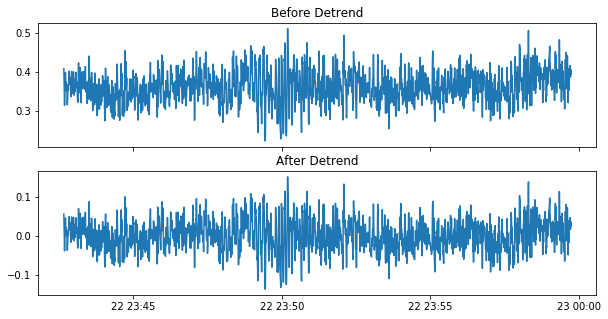

In [149]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
ax1.plot(dt_chunks[5], corrected_pressure[8192:12288])
ax1.set_title('Before Detrend')
ax2.plot(dt_chunks[5], p_chunks[4])
ax2.set_title('After Detrend')
detrend_img = './images/detrend.png'
plt.savefig(detrend_img)

In [150]:
from IPython.display import HTML

HTML("<img src='" + detrend_img + "' />")

Calculate the power spectral density of each pressure chunk:

In [151]:
#parameters are number of samples in segment and sampling time step inseconds
ogfreqs = np.fft.rfftfreq(4096,d=1/4.0)
ogfreqs = ogfreqs[1:]
psd_amps = []
for x in p_chunks:
    fft = (abs(np.fft.rfft(x))**2 / (len(x)/2)) / 4.0
    fft = fft[1:]
    psd_amps.append(fft)
   
psd_amps = np.array(psd_amps)

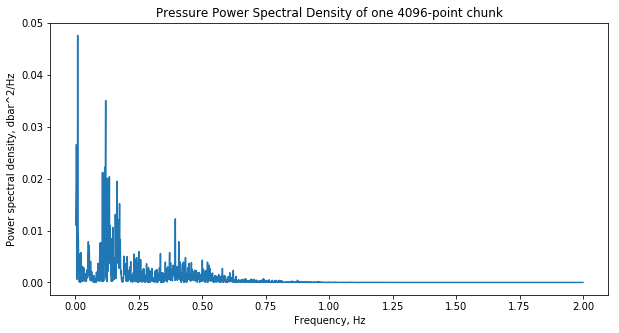

In [152]:
spectra_graph =  plot_graph(ogfreqs, 
           psd_amps[4].real, 
           'Pressure Power Spectral Density of one 4096-point chunk', 
           'Frequency, Hz', 
           'Power spectral density, dbar^2/Hz', 
           (10,5),
            'single_spectra')

In [153]:
from IPython.display import HTML

HTML("<img src='" + spectra_graph + "' />")

Band average every 16 bands and center them on the average of each band's
frequencies in order to increase the degrees of freedom and narrow the confidence
intervals of the spectral estim ates. Then, filter all energy that is greater than 1hz.

In [154]:
new_freqs = []
got_freqs = False
df = 32

psd_avg_amps = []

for x in range(0,len(psd_amps)):
    new_amps = []
    step, index = int(df/2), 0
    
    while index < len(ogfreqs):
        if got_freqs == False:
            new_freqs.append(np.average(ogfreqs[np.arange(index, index+step)]))
        
        new_amps.append(np.average(psd_amps[x][np.arange(index, index+step)]))    
        index += step;
            
    if got_freqs == False:
        got_freqs = True

    psd_avg_amps.append(np.array(new_amps))
        
#Cut off frequency within desired range (1 second to 1 minute)
freqs = np.array(new_freqs)
cutoff = np.where((freqs<=1.0) & (freqs>=0.033333333333))

freqs = freqs[cutoff]
psd_avg_amps = [psd_avg_amps[x][cutoff].real for x in range(0, len(psd_avg_amps))]

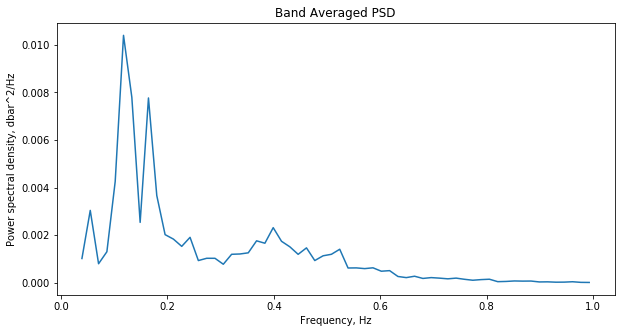

In [155]:
band_spec_graph =  plot_graph(freqs, 
           psd_avg_amps[4].real, 
           'Band Averaged PSD', 
           'Frequency, Hz', 
           'Power spectral density, dbar^2/Hz', 
           (10,5),
            'band_spectra')

In [156]:
from IPython.display import HTML

HTML("<img src='" + band_spec_graph + "' />")

Compute the 90% confidence intervals of each spectral estimate. The following is
a graph of the preceding spectral estimate with a higher and lower bound of confidence.

In [157]:
import scipy.stats as stats

x_range = [freqs for x in range(0,3)]
df = 32
ci = .9
upper = psd_avg_amps[4]*df/stats.chi2.ppf((1 - ci)/2.0, df)
lower = psd_avg_amps[4]*df/stats.chi2.ppf((1 + ci)/2.0, df)

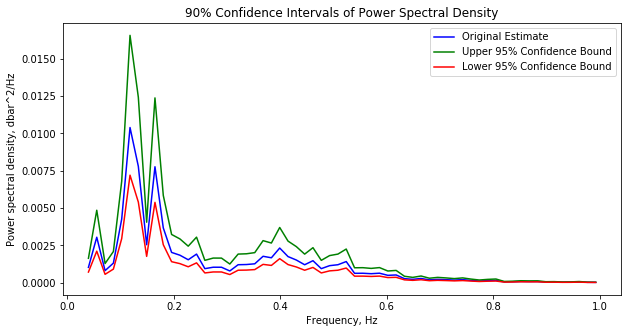

In [158]:
_, ax = plt.subplots(figsize=(10,5))
ax.plot(x_range[0], psd_avg_amps[4], color='blue', label='Original Estimate')
ax.plot(x_range[0], upper, color='green', label='Upper 95% Confidence Bound')
ax.plot(x_range[0], lower, color='red', label='Lower 95% Confidence Bound')
ax.set_title('90% Confidence Intervals of Power Spectral Density')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Power spectral density, dbar^2/Hz')
plt.legend()

cf_img = './images/cf_intervals.png'
plt.savefig(cf_img)

In [159]:
from IPython.display import HTML

HTML("<img src='" + cf_img + "' />")

Compute the wavenumber ($\hphantom{`}k\hphantom{`}$) for each frequency ($\hphantom{`}\omega\hphantom{`}$) using the dispersion
relation $\hphantom{`}ω2 = g ∗ k ∗ tanh(k ∗ h)\hphantom{`}$ where is the mean water depth determined for the
4096-point chunk, then calculate the pressure response function, (Jones &
Monismith, 2007) using the following equation:

$\hphantom{`}\Large k_{p}(z) = \frac{cosh(z * k)}{cosh(h * k)}\hphantom{`}$ <br /><br />
Where: <br />
$\hphantom{`}z\hphantom{`}$ = Height of the pressure transducer off the sea floor

In [160]:
#----------------Calculate k_p(z) for the 4096-point chunk data
from wavelab.processing.pressure_to_depth import hydrostatic_method, omega_to_k

instrument_height = [np.abs(np.mean(x) - np.mean(y)) for x,y in zip(elev_chunks, orifice_chunks)]
water_depth = [np.mean(hydrostatic_method(x, "salt")) + y for x,y in zip(og_pchunks, instrument_height)]
k_vals = [omega_to_k(freqs * 2.0 * np.pi, np.repeat(x,len(freqs))) for x in water_depth]
kz_vals = [np.array(np.cosh(i*k)/np.cosh(w*k)) for w,k,i in zip(water_depth,k_vals,instrument_height)]

Use $\hphantom{`}k_{p}^{2}\hphantom{`}$ to change the pressure PSD to a water-level PSD using the following
equation:


$\hphantom{`}\Large \eta = \frac{p}{k_{p}^{2}}\hphantom{`}$  <b>(Jones & Monismith, 2007)</b><br /><br />
Where: <br />
$\hphantom{`}p\hphantom{`}$ = Pressure PSD<br />
$\hphantom{`}\eta\hphantom{`}$ = Water Level PSD

In [161]:
from wavelab.processing.wave_stats import Stats

stats = Stats()
upper_psd, lower_psd = [], []
for x in range(0,len(psd_avg_amps)):
    u, l = stats.psd_confidence_intervals(psd_avg_amps[x],df,.9)
    upper_psd.append(u)
    lower_psd.append(l)
    
upper_psd, lower_psd = np.array(upper_psd), np.array(lower_psd)

wl_amps = [z/kz**2 for z, kz in zip(psd_avg_amps, kz_vals)]
wl_up = [z/kz**2 for z, kz in zip(upper_psd, kz_vals)]
wl_down = [z/kz**2 for z, kz in zip(lower_psd, kz_vals)]

### Calculating Wave Statistics

Calculate spectral moments by using the trapezoidal rule to integrate over the
PSD using the following equation (Carter, 1982):

$\hphantom{`}\Large m_{n} = \int_{0}^{\inf}f^{n}E(f)df\hphantom{`}$<br /><br />
Where: <br />
$\hphantom{`}m_{n}\hphantom{`}$ = The nth spectral moment

Calculate statistics based on the water level PSD.  The follow ing is a table of some statistics that are computed (Vrabel & Rendon, 2013):

| Statistic | Equation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Explanation |
| ----------------------- | --- | ------------------------ |
| Significant Wave Height (H1/3) | $\hphantom{`}4 * \sqrt{m_{0}}\hphantom{`}$ | Height of the top one third of waves |
| Top Ten Percent Wave Height (H 10%)) | $\hphantom{`}5.091 * \sqrt{m_{0}}\hphantom{`}$ | Height of the top ten percent of waves |
| Top One Percent Wave Height (H 1%) | $\hphantom{`}6.672 * \sqrt{m_{0}}\hphantom{`}$ | Height of the top one percent of waves |
| Average Zero Up Crossing Period | $\hphantom{`}\sqrt{\frac{m_{0}}{m_{2}}}\hphantom{`}$ | Length of average wave period that crosses the mean sea surface |
| Average Wave Period | $\hphantom{`}\frac{m_{0}}{m_{1}}\hphantom{`}$ | Length of average wave period |

Quick note:  For confidence intervals around significant wave height, we also need to account for the total level accuracy of the two instruments used to collect the data.  <b>This is not the same as total error bars, the USGS has done through testing at our Hyrdrologic Instrumentation Facility but more in depth testing is necessary to release total error bars for our instruments.</b>

In [162]:
# Calculate Significant Wave Height and Average Zero Upcrossing Period
h13, tavg, h13_up, h13_down = [], [], [], []

# Account for confidence intervals computed earlier as well as combined level accuracy of both deployed instruments
for x in range(0,len(wl_amps)):
    h13.append(4 * np.sqrt(Stats.moment(freqs,wl_amps[x],0)))
    h13_up.append(4 * np.sqrt(Stats.moment(freqs,wl_up[x],0)) + instrument_level_accuracy)
    h13_down.append(4 * np.sqrt(Stats.moment(freqs,wl_down[x],0)) - instrument_level_accuracy)
    tavg.append(Stats.moment(freqs,wl_amps[x],0)/Stats.moment(freqs,wl_amps[x],2))
   
final_times = []
for x in range(0,len(t_chunks)):
    final_times.append(np.mean(t_chunks[x]))

### Example Visualizations

The following is a graph of significant wave height:

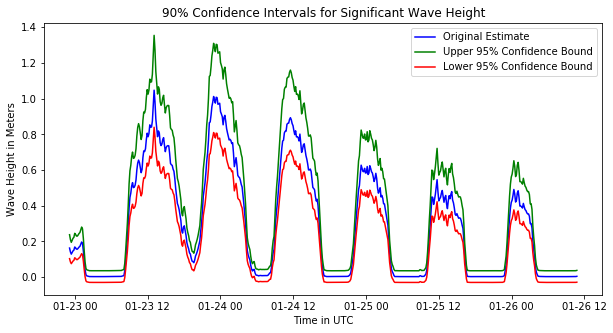

In [163]:
from wavelab.utilities.unit_conversion import convert_ms_to_date

final_dt = [convert_ms_to_date(dt,pytz.UTC) for dt in final_times]

_, ax = plt.subplots(figsize=(10,5))
ax.plot(final_dt, h13, color='blue', label='Original Estimate')
ax.plot(final_dt, h13_up, color='green', label='Upper 95% Confidence Bound')
ax.plot(final_dt, h13_down, color='red', label='Lower 95% Confidence Bound')
ax.set_title('90% Confidence Intervals for Significant Wave Height')
ax.set_xlabel('Time in UTC')
ax.set_ylabel('Wave Height in Meters')
plt.legend()

h13_img = './images/h13.png'
plt.savefig(h13_img)

In [167]:
from IPython.display import HTML

HTML("<img src='images/h13.png' />")

The following is a graph of the average zero up crossing period:

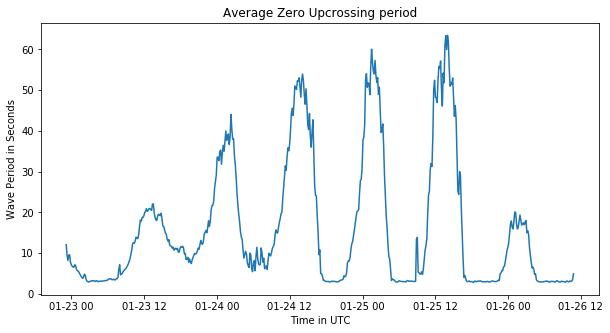

In [165]:
avg_z_png = plot_graph(final_dt, 
           tavg, 
           'Average Zero Upcrossing period', 
           'Time in UTC', 
           'Wave Period in Seconds', 
           (10,5),
            'avg_z')

In [166]:
from IPython.display import HTML

HTML("<img src='" + avg_z_png + "' />")

### References

Carter D. J. T. (1982). Prediction of Wave Height and Period For a Constant Wind Velocity Using <br />
&nbsp;&nbsp;the Jonswap Results. Pergamon Press Ltd., 9 No.1, 17-33. doi:0029-8018/010017-17
    
Earle, Marshall D. (1996). Nondirectional and Directional Wave Data Analysis Procedures. National <br />
&nbsp;&nbsp;Data Buoy Center.

Jones, N. and S. Monismith. (2007). Measuring Short Period Wind Waves in a Tidally Forced <br />
&nbsp;&nbsp;Environment with a Subsurface Pressure Gauge. Limnology and Oceanography: Methods, 5, 317-327.

SciPy (0.17.1) [Software]. (2016). SciPy, scipy.signal.welch, 1. http://www.scipy.org
    
Smith J. M. (2002). "Wave Pressure Gauge Analysis w ith Current". Journal of Waterway, Port, <br />
&nbsp;&nbsp;Coastal, and Ocean Engineering, Novemeber/Decemeber 2002, 271-275. <br />
&nbsp;&nbsp;doi:10.10161/(ASCE)0733-950X(2002)128:6(271)
        
Vrabel, J. and S. Rendon. (2013). Storm Surge, Unpublished Softw are Routine. United States <br />
&nbsp;&nbsp;Geological Survey, personal communication.